# Public Goods Simulation Visualizer
This notebook reads simulation summary data and snapshot JSON to visualize cooperation dynamics.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import re

import tikzplotlib
import os


os.makedirs("figures", exist_ok=True)
model_to_plot = "B"   # or "B"

In [20]:
FNAME_RE = re.compile(
    r"r(?P<r0>\d{2})v(?P<sigma>\d{3})_(?P<ftype>[^_]+)_L(?P<L>\d+)_(?P<model>A|B)(?:_tau(?P<tau>\d+))?_summary\.csv$"
)

def parse_meta(path):
    m = FNAME_RE.search(os.path.basename(path))
    if not m:
        return None
    r0 = int(m.group("r0"))/10.0
    sigma = int(m.group("sigma"))/100.0
    ftype = m.group("ftype")
    L = int(m.group("L"))
    model = m.group("model")
    tau = int(m.group("tau")) if m.group("tau") else int(0)
    alpha = round(sigma / r0, 4)
    return dict(r0=r0, sigma=sigma, ftype=ftype, L=L, model=model, tau=tau, alpha=alpha)

files = sorted(glob.glob("data/*_summary.csv"))
rows = []
for f in files:
    meta = parse_meta(f)
    if not meta:
        continue
    if meta["model"] != model_to_plot:
        continue
    df = pd.read_csv(f)
    if "C" not in df.columns and "Cooperator" in df.columns:
        df = df.rename(columns={"Cooperator":"C"})
    df["time"] = df.get("time", pd.Series(range(len(df))))
    for k,v in meta.items():
        df[k] = v
    rows.append(df)

df_all = pd.concat(rows, ignore_index=True)

# Final state
df_final = df_all.sort_values("time").groupby(
    ["r0","sigma","alpha","ftype","L","model","tau"], as_index=False
).tail(1)
df_final

,time,C,mean_payoff,var_payoff,r0,sigma,ftype,L,model,tau,alpha
529,1000,0.8250,2.519910,1.254030,5.0,2.00,uniform,100,B,1000,0.4
468,1000,0.9649,20.938600,2.872330,5.0,1.00,uniform,100,B,10,0.2
5,1000,0.0000,0.000000,0.000000,2.0,0.20,uniform,100,B,10,0.1
535,1000,0.0000,0.000000,0.000000,5.0,2.50,uniform,100,B,10,0.5
2,1000,0.0000,0.000000,0.000000,2.0,0.20,uniform,100,B,1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
365,1000,0.0026,0.034041,0.246691,4.5,1.35,uniform,100,B,1,0.3
68,1000,0.0000,0.000000,0.000000,2.5,0.75,uniform,100,B,10,0.3
368,1000,0.0000,0.000000,0.000000,4.5,1.35,uniform,100,B,10,0.3
77,1000,0.0000,0.000000,0.000000,2.5,1.00,uniform,100,B,10,0.4


In [21]:
def _arrays(df, x="r0", y1="C", y2="mean_payoff", v2="var_payoff"):
    x = df[x].to_numpy()
    y_c = df[y1].to_numpy()
    y_m = df[y2].to_numpy()
    y_se = np.sqrt(df[v2].to_numpy())
    return x, y_c, y_m, y_se

def _title(model, alpha=None, L=None, tau=None):
    parts = []
    if alpha is not None: parts.append(rf'$\alpha={alpha:.1f}$')
    if L is not None:     parts.append(rf'$L={int(L)}$')
    if model == "B" and tau is not None:
        parts.append(rf'$\tau={tau}$')
        parts.append(r'$\mathrm{Model\ B}$')
    elif model == "A":
        parts.append(r'$\mathrm{Model\ A}$')
    return r',$\quad$ '.join(parts) if parts else None

def _save(fig, path, tikz=False, tikz_kwargs=None):
    if not path: return
    os.makedirs(os.path.dirname(path), exist_ok=True)
    if tikz:
        import tikzplotlib
        tikzplotlib.save(path, **(tikz_kwargs or {}))
    else:
        fig.savefig(path, dpi=200, bbox_inches='tight')

def fig_name_alpha_tau(model, alpha, L, tau=None, ext="tex"):
    if model == "A":
        return f"alpha_{alpha:.1f}_A.{ext}"
    return f"alpha_{alpha:.1f}_tau{int(tau):05d}_B.{ext}"

# --- main plotting function ---
def plot_dual_axis_by_r0(
    df_subset,
    *,
    alpha_value=None, tau_value=None,          # for title/filename
    save_path=None, save_tikz=False,
    x_col="r0", y1_col="C", y2_col="mean_payoff", y2_var_col="var_payoff",
    model_col="model", L_col="L",
    show=True, return_fig=False
):
    if df_subset.empty:
        raise ValueError("df_subset is empty")

    model = str(df_subset[model_col].iloc[0])
    L_val = int(df_subset[L_col].iloc[0]) if L_col in df_subset else None
    x, y_c, y_m, y_se = _arrays(df_subset, x_col, y1_col, y2_col, y2_var_col)

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.set_prop_cycle(None)  # predictable colours

    # left: C (blue)
    ax1.plot(x, y_c, marker='o', markersize=1, linewidth=1.5,
             color='tab:blue', label='Cooperator ratio (C)')
    ax1.set_xlabel(r'$r_0$')
    ax1.set_ylabel('Cooperator Ratio', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(-0.05, 1.05)

    # right: mean payoff (red) + SE
    ax2 = ax1.twinx()
    ax2.set_prop_cycle(None)
    ax2.plot(x, y_m, marker='s', markersize=1, linewidth=1.5,
             color='tab:red', label='Mean payoff')
    ax2.errorbar(x, y_m, yerr=y_se, fmt='none',
                 ecolor='tab:red', alpha=0.5, capsize=3)
    ax2.set_ylabel('Mean Payoff', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    title = _title(model, alpha_value, L_val, tau_value)
    if title: plt.title(title)
    fig.tight_layout()

    _save(fig, save_path, tikz=save_tikz)

    if show:
        from IPython.display import display
        display(fig)
    if return_fig:
        return fig, ax1, ax2
    plt.close(fig)

In [22]:
def render_alpha_plots(df_final, model_to_plot, save_dir="figures", save_tikz=True, show_inline=True):
    import os
    os.makedirs(save_dir, exist_ok=True)

    df = df_final.copy()
    df['tau'] = df.get('tau', 0).fillna(0).astype(int)
    df = df[df['model'] == model_to_plot]
    if df.empty:
        raise ValueError(f"No rows for model={model_to_plot}")

    # Grouping scheme: A -> by alpha; B -> by (alpha, tau>0)
    keys = ['alpha'] if model_to_plot == 'A' else ['alpha', 'tau']

    n = 0
    for key_vals, sub in df.groupby(keys, sort=True):
        # Unpack keys
        if model_to_plot == 'A':
            alpha, tau = float(key_vals[0]), 0
        else:
            alpha, tau = float(key_vals[0]), int(key_vals[1])
            if tau <= 0:  # guard against stray zeros
                continue

        sub = sub.sort_values('r0')
        if sub.empty:
            continue
        L_val = int(sub['L'].iloc[0])

        save_path = os.path.join(
            save_dir,
            fig_name_alpha_tau(model_to_plot, alpha, L_val, tau=tau, ext="tex")
        )

        # Render + save (plot function handles display/close)
        plot_dual_axis_by_r0(
            sub,
            alpha_value=alpha,
            tau_value=tau,
            save_path=save_path,
            save_tikz=save_tikz,
            show=show_inline
        )
        n += 1

    print(f"[done] generated {n} plot(s) for model {model_to_plot} → {save_dir}")

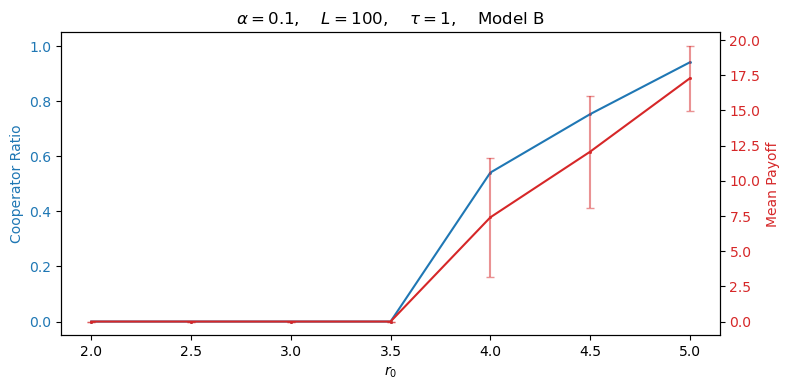

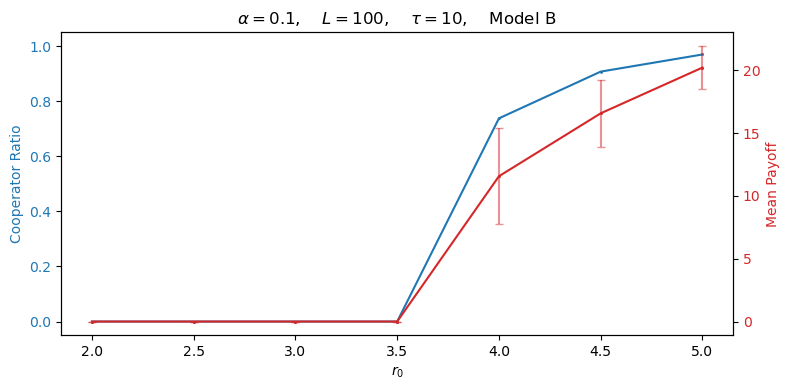

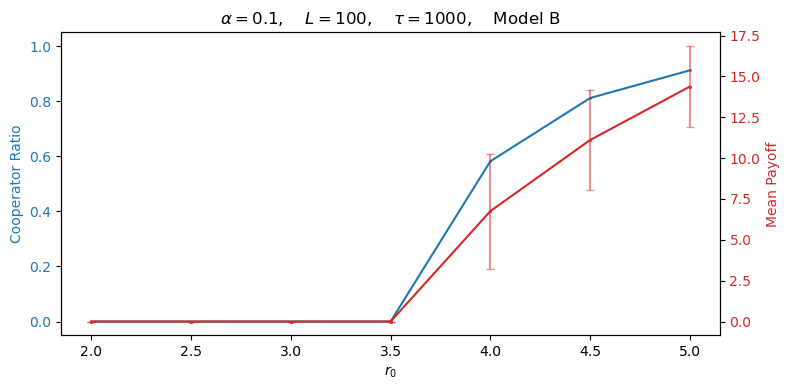

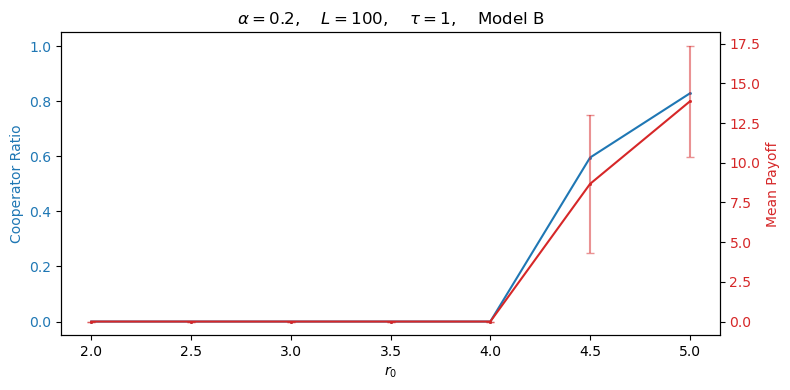

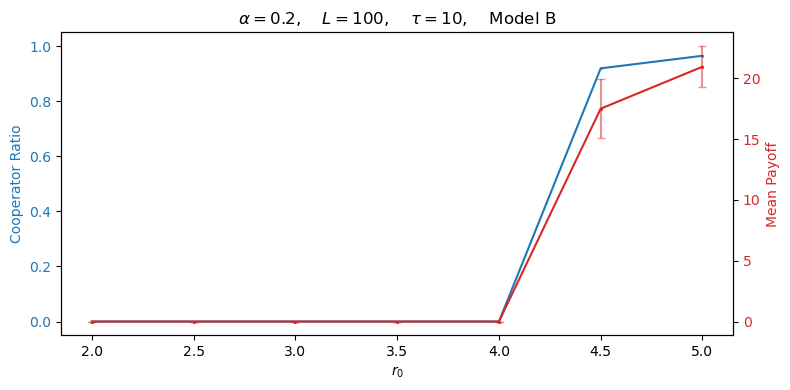

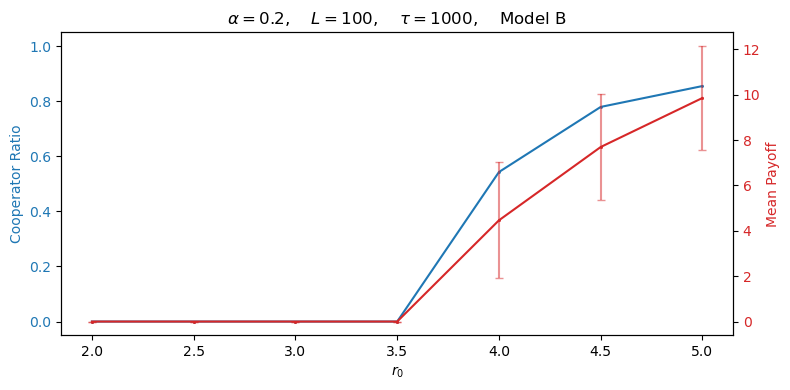

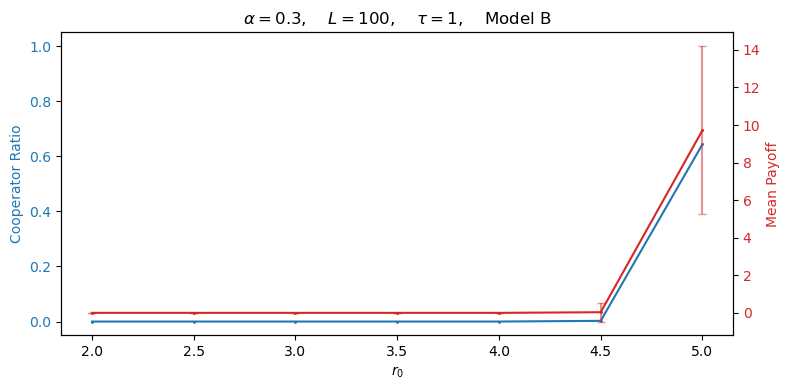

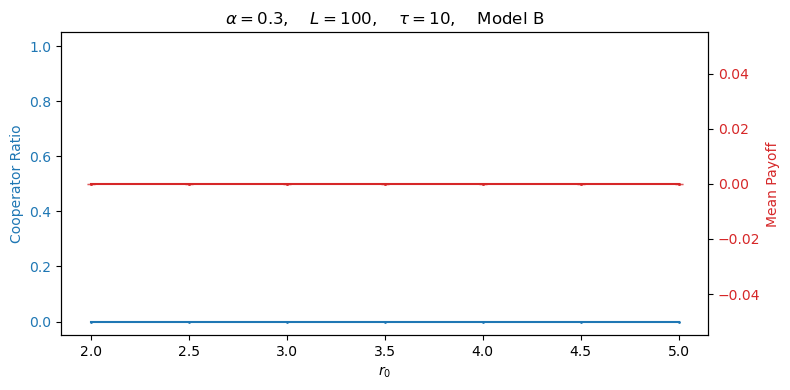

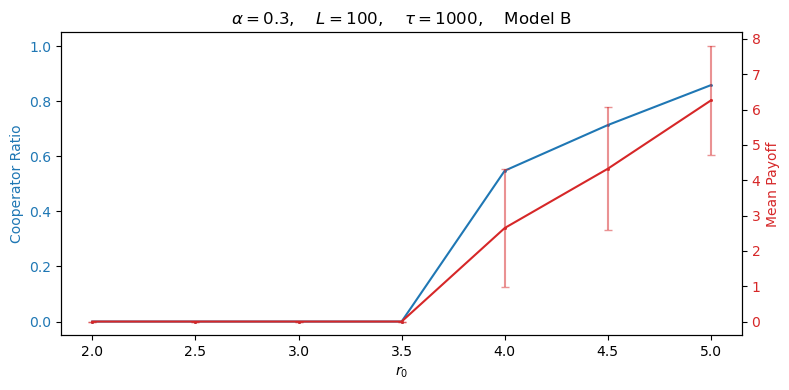

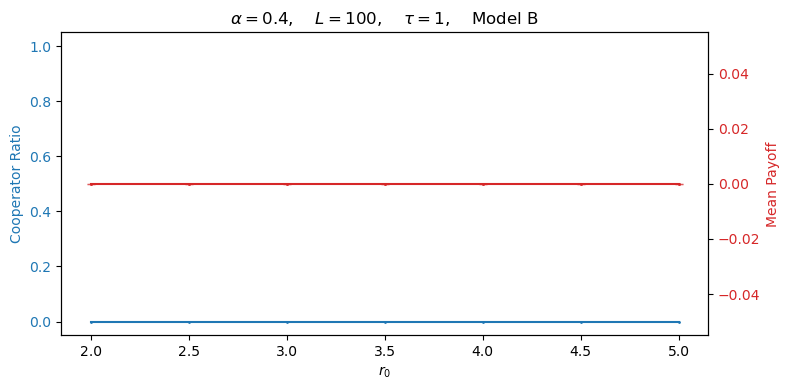

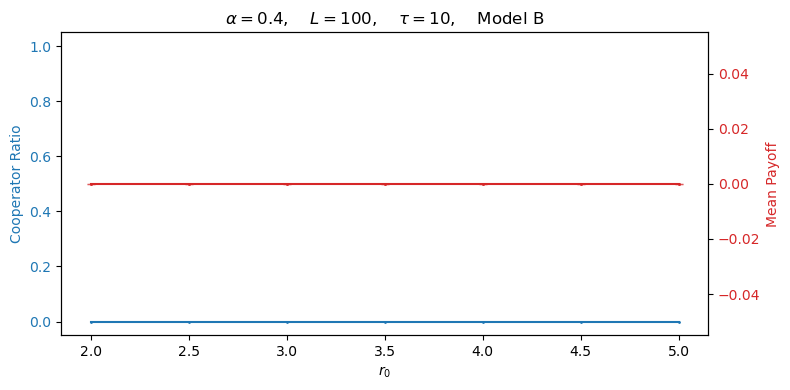

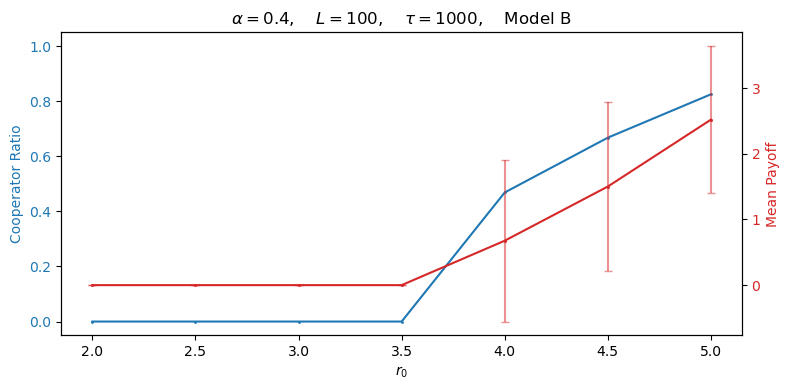

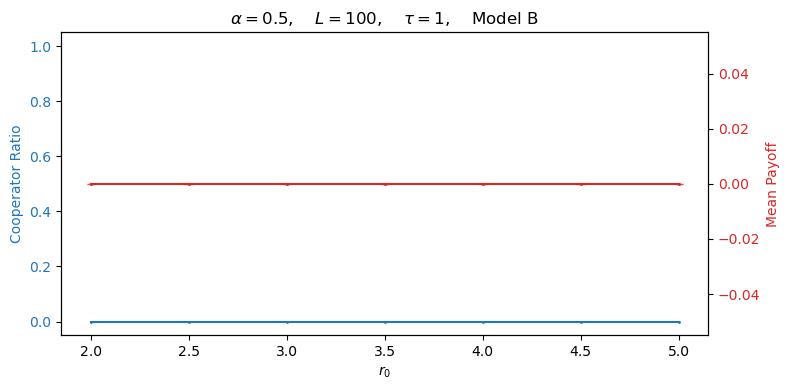

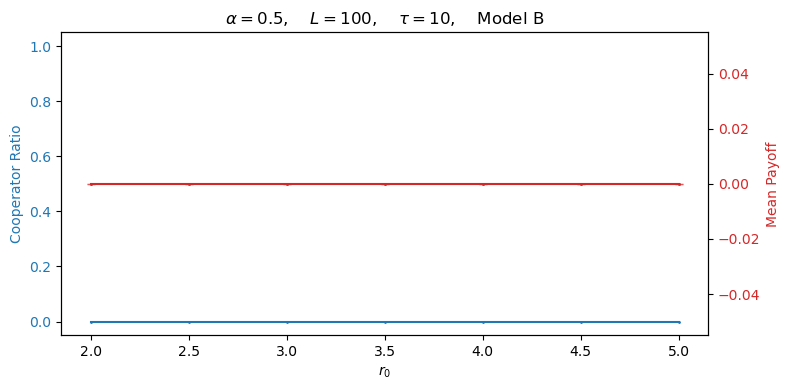

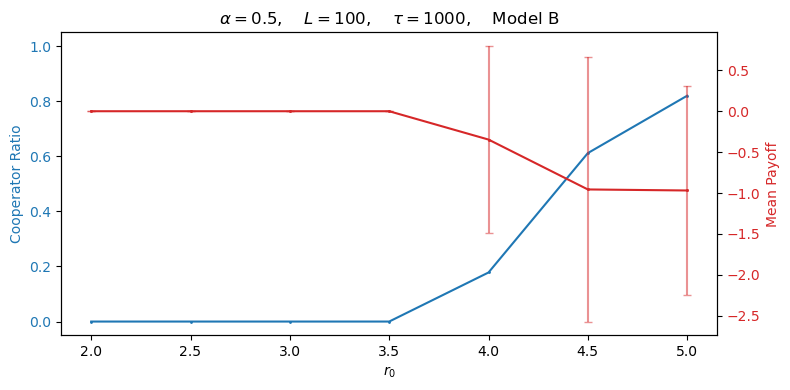

[done] generated 15 plot(s) for model B → figures


In [23]:
render_alpha_plots(df_final, model_to_plot, save_dir="figures", save_tikz=True)